# Analisi di documenti simili #

Una delle applicazioni dellSe tecniche di analisi dei documenti simili &egrave; legata alle procedure volte a eliminare record che si riferiscono alla stessa entit&agrave; quando si fondono due o pi&ugrave; fonti di dati. A tali procedure ci si riferisce utilizzando tipicamente il nome *entity resolution* o *record linkage*, ma nel gergo tecnico esiste una vasta gamma di termini pi&ugrave; o meno equivalenti, quali per esempio *entity disambiguation*, *entity linking*, *duplicate detection*, *deduplication*, *record matching*, *conflation*, *reconciliation* o, pi&ugrave; genericamente *data integration*)

Si parla dunque di entity resolution quando si vogliono rilevare record in una fonte dati che si riferiscono tutti a una stessa entit&agrave;, tipicamente a seguito dell'integrazione di fonti dati diverse e a fronte di descrizioni non identiche di uno stesso oggetto.

## Strumenti
Questo tutorial &egrave; basato sull'uso di funzionalità base di Python 2.7, di Spark 1.4.1 associato alle API pySpark e della libreria grafica matplotlib. Verr&agrave; fatto uso delle librerie standard per le espressioni regolari: nel caso in cui sia necessario un ripasso, il sito [regex101](https://regex101.com/) permette di applicare espressioni regolari su stringhe in modo interattivo.

In [10]:
import pyspark
sc = pyspark.SparkContext('local[*]')

## File
I dati utilizzati fanno parte del progetto [metric-learning](https://code.google.com/archive/p/metric-learning/source). I file corrispondenti, memorizzati nella directory `data`, sono i seguenti:

* `Google.csv`, dataset di prodotti estratto da Google,
* `Amazon.csv`, dataset di prodotti estratto da Amazon,
* `Google_small.csv`, \\(200\\) record campionati da `Google.csv`,
* `Amazon_small.csv` \\(200\\) record campionati da `Amazon.csv`,
* `Amazon_Google_perfectMapping.csv`, mapping tra i record dei due dataset che si riferiscono a uno stesso prodotto,
* `stopwords.txt`, un elenco di stop word per la lingua inglese.

Useremo i file contenenti i record campionati nella prima parte del tutorial, così da poter sperimentare senza che l'elaborazione richieda di attendere troppo tempo. Il file che indica quali coppie di record si riferiscano allo stesso prodotto (informazione che prende il nome di *gold standard* o *ground truth*) verrà usato per valutare la performance dell'algoritmo proposto.

Memorizziamo i nomi di questi file in altrettante costanti:

In [13]:
import sys
import os

DATA_DIR = 'data/'

base_dir = os.path.join(DATA_DIR)

GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

## 0. Operazioni preliminari ##

Iniziamo creando un RDD per ciascuno dei due dataset. In essi, ogni linea fa riferimento a un prodotto, utilizzando il formato

    `"id","nome","descrizione","produttore","prezzo"`

descritto nella prima linea di ogni file (che non dovr&agrave; quindi essere considerata). Va anche notato che i doppi apici fanno parte delle varie stringhe e che gli identificativi hanno una forma differente nei due dataset: sono URL per i dati di Google e codici alfanumerici per i dati di Amazon.

Iniziamo costruendo degli RDD in cui gli elementi siano delle coppie in cui la chiave indica l'identificativo e il valore il resto della linea. Il parsing dei doppi apici va considerato con attenzione, perch&eacute; quando un dato &egrave; mancante (come capita per esempio con il produttore) i file contengono una stringa vuota non delimitata da doppi apici. Vale quindi la pena utilizzare le virgole come punti di riferimento per costruire un'espressione regolare che indichi il formato di una linea dei file (cinque campi separati da virgola, dei quali i primi due non possono essere mancanti):

In [14]:
import re
DATAFILE_PATTERN = '^(.+),(.+),(.*),(.*),(.*)'

Una volta verificato che una linea corrisponde a questa espressione regolare potremo procedere, ove serve, a eliminare i doppi apici, utilizzando la funzione che segue.

In [15]:
def remove_quotes(s):
    """ Remove quotation marks from an input string
    
    Args:
        s (str): input string that might have the quote "" characters
    
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')

Siamo ora pronti a scrivere la funzione che si occuperà del parsing di una linea, verificando innanzitutto che quest'ultima segua il formato richiesto (restituendo una coppia contenente la linea e il valore speciale `-1` altrimenti) e identificando la prima riga dei file che contiene le intestazioni (restituendo una coppia contenente la linea e il valore speciale `0`). Infine i valori per i campi andranno recuperati al fine di costruire una coppia avente come chiave l'identificativo del prodotto (dopo avere eliminato i doppi apici) e come valore i restanti campi giustapposti. Tale oggetto dovr&agrave; essere restituito inserendolo come primo elemento in una coppia, il cui secondo elemento sar&agrave; il valore speciale `1`. In questo modo sar&agrave; possibile verificare quante linee dei file sono state convertite correttamente.

In [39]:
def parse_datafile_line(datafile_line):
    """ Parse a line of the data file using the specified regular expression
    pattern
    
    Args:
        datafileLine (str): input string that is a line from the data file
    
    Returns:
        str: a string parsed using the given regular expression and without
             the quote characters
    """
    
    match = re.search(DATAFILE_PATTERN, datafile_line.decode('utf-8'))
    if match is None:
        print('Invalid datafile line: {}'.format(datafile_line))
        return (datafile_line, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: {}'.format(datafile_line))
        return (datafile_line, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((remove_quotes(match.group(1)), product), 1)

Il passo successivo &egrave; quello di definire una funzione che crei un RDD contenente un elemento per ogni linea di un file, per poi mapparvi sopra la funzione `parse_dataline_file` appena definita, mettendo in *cache* il risultato.

In [40]:
def parse_data(filename):
    """ Parse a data file
    
    Args:
        filename (str): input file name of the data file
        
    Returns:
        RDD: a RDD of parsed lines
    """
    
    return (sc
            .textFile(filename, 4, 0)
            .map(parse_datafile_line)
            )

&Egrave; ora possibile costruire una funzione che dato il nome di un dataset si occupa di creare il corrispondente RDD, e verifica che non vi siano stati errori di conversione. Ci&ograve; viene fatto:
* costruendo l'RDD che si ottiene filtrando il numero di coppie che contengono il valore speciale `-1` e selezionando il loro primo elemento (ottenendo le linee che non sono convertibili);
* stampando il contenuto di (al pi&ugrave;) dieci linee siffatte;
* costruendo l'RDD che corrisponde alle coppie che contengono il valore `0` e selezionandone il primo elemento (ovvero una coppia `(id, prodotto)` ottenuta a seguito di una conversione valida)
* inserendo l'RDD dei valori convertiti in *cache*;
* verificando che non siano avvenuti errori di conversione e che tutte le righe del file siano state effettivamente convertite;
* restituendo l'RDD dei valori convertiti.

In [46]:
def load_data(path):
    """ Load a data file
    
    Args:
        path (str): input file name of the data file
        
    Returns:
        RDD: a RDD of parsed valid lines
    """
    
    filename = os.path.join(base_dir, path)
    raw = parse_data(filename).cache()
    
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    
    for line in failed.take(10):
        #print('{} - Invalid datafile line: {}'.format(path, line))
        print(line)
        
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print('{} - Read {} lines, successfully parsed {} lines, '
           'failed to parse {} lines'.format(path,
                                             raw.count(),
                                             valid.count(),
                                             failed.count()))
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

Utilizzando le funzioni scritte si possono effettuare le conversioni dei dataset che verranno utilizzati.

In [47]:
google_small = load_data(GOOGLE_SMALL_PATH)
google = load_data(GOOGLE_PATH)
amazon_small = load_data(AMAZON_SMALL_PATH)
amazon = load_data(AMAZON_PATH)

Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


Verifichiamo il contenuto di alcuni record nei due dataset convertiti:

In [49]:
for line in google_small.take(3):
    print('google: {}: {}\n'.format(line[0], line[1]))

for line in amazon_small.take(3):
    print('amazon: {}: {}\n'.format(line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: "spanish vocabulary builder" "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: "topics presents: museums of world" "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: "sierrahome hse hallmark card studio special edition win 98 me 2000 xp" "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: "clickart 950 000 - premier image pack (dvd-rom)"  "broderbund"

amazon: b0006zf55o: "ca international - arcserve lap/desktop oem 30pk" "oem arcser

## 1. Codificare documenti tramite *bag of words* ##

Un modo naturale di effettuare entity resolution su documenti testuali &egrave; quello di considerare ogni record come una stringa e utilizzare una distanza tra stringhe per calcolare la similiarit&agrave; tra due documenti. In particolare utilizzeremo il cosiddetto approccio *bag of words*, in cui un documento testuale &egrave; codificato in termini di un insieme di parole o, meglio ancora, *token* che occorrono in esso.

> **Nota**: si preferisce parlare di *token* per enfatizzare che non si tratta necessariamente di una parola, bens&igrave; di un «atomo» indivisibile che potrebbe essere una parola ma anche una sottostringa di lunghezza fissata (\\(k\\)-gramma) che occorre nel testo.

I token divengono gli elementi che ci permettono di effettuare un confronto tra documenti, la cui similarit&agrave; può essere espressa in termini del numero di token in comune.

### 1.1 Estrarre token da una stringa ###

Implementiamo una funzione `simple_tokenize` che data una stringa restituisce la lista dei token in essa contenuti, intesi come parole delimitate da spzi bianchi. Questa funzione utilizza opportunamente le espressioni regolari e sar&agrave; *case insensitive*, prendendosi inoltre cura di non considerare eventuali token vuoti.

In [50]:
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simple_tokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return [s for s in re.split(split_regex, string.lower()) if s != '']

Verifichiamo che la funzione si comporti correttamente su un semplice caso di test, che non consideri gli spazi vuoti e che non elimini eventuali token duplicati.

In [51]:
print(simple_tokenize(quickbrownfox))

assert(simple_tokenize(quickbrownfox) ==
       ['a','quick','brown','fox','jumps','over','the','lazy','dog'])
assert(simple_tokenize(' ') == [])
assert(simple_tokenize('!!!!123A/456_B/789C.123A') == ['123a','456_b','789c','123a'])
assert(simple_tokenize('fox fox') == ['fox', 'fox'])

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


### 1.2 Eliminare le stop word ###

Si indicano con il termine *stop word* le parole che appaiono comunemente nei testi scritti in una fissata lingua, e che dunque non apportano particolare contenuto informativo. Per tale motivo &egrave; opportuno eliminare tali parole prima di estrarre token da un documento. Utilizzando il file `stopwords.txt` implementiamo la funzione `tokenize` che si comporta in modo analogo a `simple_tokenize` ma che ignora le *stop word*.

In [54]:
stopfile = os.path.join(base_dir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())

print('These are the stopwords: {}'.format(stopwords))

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    
    Args:
        string (str): input string
        
    Returns:
        list: a list of tokens without stopwords
    """
    return [s for s in re.split(split_regex, string.lower())
            if s != '' and not s in stopwords]

These are the stopwords: {'ours', 'his', 'above', 'being', 'ourselves', 'these', 'there', 'that', 'between', 'don', 'further', 'myself', 'were', 'by', 'more', 'those', 'while', 'until', 'about', 's', 'during', 'then', 'too', 'because', 'if', 'below', 'no', 'from', 'how', 'a', 'he', 'on', 'off', 'all', 'into', 'and', 'very', 'under', 'as', 'has', 'yourself', 'only', 'her', 'other', 'yourselves', 'an', 'they', 'what', 'some', 'hers', 'them', 'had', 'down', 'the', 'itself', 'which', 'do', 'your', 'have', 'been', 'up', 'through', 'than', 'but', 'theirs', 'not', 'once', 'having', 'when', 'nor', 'him', 'whom', 'their', 'was', 'for', 'own', 'to', 'where', 'before', 'here', 'this', 'with', 'at', 'both', 'you', 'out', 'of', 'just', 'i', 'now', 'each', 'few', 'any', 'against', 'does', 'my', 'himself', 'themselves', 'over', 'me', 'yours', 'we', 'most', 'so', 'doing', 'again', 'she', 'am', 'such', 'why', 'its', 'after', 'or', 'who', 'same', 'herself', 'can', 'in', 't', 'be', 'is', 'it', 'are', 'wi

Anche in questo caso, verifichiamo alcuni semplici test: la funzione deve eliminare le *stop word* ma considerare tutti gli altri termini.

In [55]:
print(tokenize(quickbrownfox))

assert(tokenize("Why a the?") == [])
assert(tokenize("Being at the_?") == ['the_'])
assert(tokenize(quickbrownfox) == ['quick','brown','fox','jumps','lazy','dog'])

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


### 1.3 Estrarre i token dai dataset campionati ###

Iniziamo a estrarre i token dai due dataset campionati, applicando `tokenize` a ogni elemento dell'RDD corrispondente.

In [56]:
amazon_rec_to_token = amazon_small.map(lambda s: (s[0], tokenize(s[1])))
google_rec_to_token = google_small.map(lambda s: (s[0], tokenize(s[1])))

Come prima analisi, provvediamo a contare il numero totale di token contenuti nei due dataset.

In [57]:
def count_tokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    return vendorRDD.map(lambda s: len(s[1])).reduce(lambda a, b: a+b)

In [58]:
total_tokens = count_tokens(amazon_rec_to_token) + count_tokens(google_rec_to_token)
print('There are {} tokens in the combined datasets'.format(total_tokens))
assert(total_tokens == 22520)

There are 22520 tokens in the combined datasets


### 1.d Determinare quale documento ha pi&ugrave; token ###

Quale documento del dataset di Amazon ha il maggior numero di token? Per saperlo basta ordinare opportunamente i record.

In [60]:
def find_biggest_record(vendorRDD):
    """ Find and return the record with the largest number of tokens
    
    Args:
        vendorRDD (RDD of (recordId, tokens)): input Pair Tuple of record ID and tokens
        
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    return vendorRDD.takeOrdered(1, key = lambda s: -1*len(s[1]))

biggest_record_amazon = find_biggest_record(amazon_rec_to_token)
print('The Amazon record with ID "{}"'
      ' has the most tokens ({})'.format(biggest_record_amazon[0][0],
                                         len(biggest_record_amazon[0][1])))

assert(biggest_record_amazon[0][0] == 'b000o24l3q')
assert(len(biggest_record_amazon[0][1]) == 1547)

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


## 2. Uso della misura TF.IDF ##

Per migliorare la tecnica basata su *bag of words* &egrave; importante dare pesi diversi ai token contenuti in un documento, in modo da riflettere quali siano i termini pi&ugrave; rilevanti. Un'euristica che permette di capire quali siano questi termini &egrave; la *misura TF.IDF* (Term Frequency times Inverse Document Frequency), ottenuta moltiplicando tra loro due indicatori definiti qui di seguito.

### Term Frequency ###

La *Term Frequency* d&agrave; maggior peso a token che tendono a occorrere pi&ugrave; volte in uno stesso documento. Viene calcolata come la frequenza relativa del token nel documento. In altre parole, se il documento \\(d\\) contiene \\(100\\) token e tra questi il token \\(t\\) occorre in \\(d\\) cinque volte, la Term Frequency di \\(t\\) in \\(d\\) vale \\(\mathrm{TF}(t, d) = \frac{5}{100} = \frac{1}{20}\\).

### Inverse Document Frequency ###

La *Inverse Document Frequency* d&agrave; un peso alto a token che occorrono raramente su un dataset. Dato un token \\(t\\) e un insieme di documenti \\(U\\), la Inverse Document Frequency di \\(t\\) &egrave; uguale a \\(\mathrm{IDF}(t) = \frac{N}{n(t)}\\), dove \\(N\\) &egrave; il numero totale di documenti in \\(U\\) e \\(n(t)\\) indica il numero di documenti in \\(U\\) che contengono \\(t\\). 

### TF.IDF ###

La misura TF.IDF di un token \\(t\\) in un documento \\(d\\) &egrave; pari al prodotto tra la Term Frequency e la Inverse Document Frequency: \\(\mathrm{TF.IDF}(t, d)= \mathrm{TF}(t, d) \cdot \mathrm{IDF(t)}\\). Informalmente, un'elevata TF.IDF indica un token che occorre spesso in un documento ma raramente negli altri, e quindi andr&agrave; dato più peso, nel calcolo della similarit&agrave; tra due documenti, al fatto che entrambi contengano un termine avente un'alto valore della misura TF.IDF.

### 2.1 Implementare una funzione per la Term Frequency ###

Implementiamo una funzione `tf` che data una lista di token restituisce un dizionario che trasforma ogni token nella corrispondente misura TF. La funzione opera nel modo seguente:

* crea un dizionario vuoto;
* per ogni token nella lista passata come argomento, lo aggiunge come chiave associata a \\(1\\) se gi&agrave; non occorre nel dizionario, altrimenti incrementa di un'unità il valore associato;
* per ogni token nel dizionario, divide il valore associato per il numero totale di token nella lista passata come argomento.

In [61]:
def tf(tokens):
    """ Compute TF
    
    Args:
        tokens (list of str): input list of tokens from tokenize
        
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    val = {}
    for t in tokens:
        if t in val:
            val[t] += 1
        else:
            val[t] = 1.0
    for t in val:
        val[t] /= len(tokens)
    return val

Anche in questo caso, verifichiamo che la funzione `tf` passi alcuni test di base.

In [62]:
print(tf(tokenize(quickbrownfox)))
tf_test = tf(tokenize(quickbrownfox))
assert(tf_test == {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                             'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                             'dog': 0.16666666666666666, 'quick': 0.16666666666666666})
tf_test2 = tf(tokenize('one_ one_ two!'))
assert(tf_test2 == {'one_': 0.6666666666666666, 'two': 0.3333333333333333})

{'quick': 0.16666666666666666, 'brown': 0.16666666666666666, 'fox': 0.16666666666666666, 'jumps': 0.16666666666666666, 'lazy': 0.16666666666666666, 'dog': 0.16666666666666666}


### 2.2 Creare un corpus di documenti ###

Il passo successivo è quello di creare un RDD che funga da *corpus* contenente tutti i documenti che vogliamo analizzare, e quindi sia il risultato della fusione tra il dataset di Amazon e quello di Google. Ogni elemento di questo nuovo RDD sar&agrave; una coppia contenente come chiave l'identificatore di un prodotto e come valore la sua descrizione (a seguito delle operazioni di ripulitura).

In [63]:
corpusRDD = google_rec_to_token.union(amazon_rec_to_token)

In [64]:
assert(corpusRDD.count() == 400)

### 2.3 Implementare una funzione per l'Inverse Document Frequency ###

Implementiamo una funzione `idfs` che assegna il valore di Inverse Document Frequency a ogni token che occorre in un corpus di documenti, restituendo un RDD di coppie \\((t, i)\\) dove \\(t\\) e \\(i\\) sono rispettivamente un token e il relativo valore di IDF.

La funzione eseguir&agrave; i seguenti passi:

* calcolare \\(N\\), il numero di documenti del corpus;
* creare un RDD che per ogni documento del corpus contenga tutti i token unici che vi occorrono; in altre parole, per ogni documento sarà necessario includere ogni token una volta sola, *anche nel caso in cui esso occorra più volte nel documento*;
* per ognuno dei token unici \\(t\\), contare quante volte occorre nel corpus per calcolare \\(n(t)\\) e successivamente l'Inverse Document Frequency per \\(t\\).

In [65]:
def idfs(corpus):
    """ Compute IDF

    Args:
        corpus (RDD): input corpus

    Returns:
        RDD: a RDD of (record ID, IDF value)
    """
    
    N = corpus.count() * 1.0
    unique_tokens = corpus.map(lambda s: list(set(s[1])))
    token_count_pair_tuple = unique_tokens.flatMap(lambda t: [(s, 1) for s in t])
    token_sum_pair_tuple = token_count_pair_tuple.reduceByKey(lambda a, b: a+b)
    return token_sum_pair_tuple.map(lambda s: (s[0], N/s[1]))

Usando la funzione `idfs` &egrave; possibile calcolare i valori IDF per tutti i token in `corpusRDD`, l'unione dei due dataset campionati, e determinare il numero di token unici.

In [66]:
idfs_small = idfs(corpusRDD)
unique_token_count = idfs_small.count()

print('There are {} unique tokens'
      ' in the small datasets.'.format(unique_token_count))

assert(unique_token_count == 4772)
token_smallest_IDF = idfs_small.takeOrdered(1, lambda s: s[1])[0]
assert(token_smallest_IDF[0] == 'software')
assert(abs(token_smallest_IDF[1] - 4.25531914894) < 0.0000000001)

There are 4772 unique tokens in the small datasets.


### 2.4 Determinare i token con i pi&ugrave; piccoli valori IDF ###

Ordinando opportunamente l'RDD che contiene i valori IDF &egrave; possibile stampare gli \\(11\\) token con i valori IDF pi&ugrave; bassi.

In [67]:
small_IDF_tokens = idfs_small.takeOrdered(11, lambda s: s[1])
print(small_IDF_tokens)

[('software', 4.25531914893617), ('features', 6.896551724137931), ('new', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('cd', 8.333333333333334), ('create', 8.333333333333334), ('system', 8.333333333333334), ('windows', 8.51063829787234), ('1', 8.51063829787234)]


### 2.5 Istogramma dei valori IDF ###

Possiamo ora visualizzare un istogramma dei valori IDF nel corpus, utilizzando la libreria `matplotlib`.

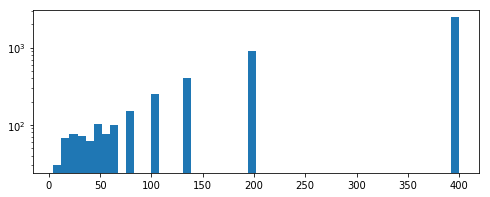

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

small_idf_values = idfs_small.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
plt.show()

### 2.6 Implementare una funzione per il calcolo di TF.IDF ###

Utilizziamo la fuzione `tf` per implementare una nuova funzione `tfidf` che, dati in ingresso una lista di token in un documento e il dizionario restituito da `idfs`, restituisce un dizionario che associa ai token nella lista il corrispondente valore della misura TF.IDF.

La funzione si occuper&agrave; di
* calcolare il TF per tutti i token nella lista, e
* creare un dizionare in cui ogni token viene associato al proprio valore TF moltiplicato per il corrispodente valore IDF.

In [70]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tf_idf_dict = {t: tfs[t]*idfs[t] for t in tokens}
    return tf_idf_dict

Applichiamo la funzione `tfidf` al calcolo della misura TF.IDF per il prodotto di Amazon il cui ID vale `b000hkgj8k`. Tale operazione richieder&agrave; di estrarre il record corrispondente dal dataset di Amazon, nonché di convertire l'RDD che contiene i valori IFS per il corpus in un dizionario. Il primo compito si effettua facilmente applicando un'operazione di filtraggio, mentre per il secondo &egrave; possibile sfruttare l'azione `collectAsMap`.

In [72]:
recb000hkgj8k = amazon_rec_to_token.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfs_small_weights = idfs_small.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfs_small_weights)

print('Amazon record "b000hkgj8k" '
      'has tokens and weights:\n{}'.format(rec_b000hkgj8k_weights))

assert(rec_b000hkgj8k_weights ==
                   {'autocad': 33.33333333333333, 'autodesk': 8.333333333333332,
                    'courseware': 66.66666666666666, 'psg': 33.33333333333333,
                    '2007': 3.5087719298245617, 'customizing': 16.666666666666664,
                    'interface': 3.0303030303030303})

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 33.33333333333333, '2007': 3.5087719298245617, 'courseware': 66.66666666666666, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303, 'autodesk': 8.333333333333332, 'psg': 33.33333333333333}


## 3. Uso della distanza del coseno ##

Una possibile distanza tra documenti è la cosiddetta *distanza del coseno*, che interpreta due oggetti come direzioni in uno spazio e calcola il coseno dell'angolo che queste direzioni formano.

La prima difficolt&agrave; consiste nel codificare i documenti come direzioni nello spazio, e quindi come vettori. In realt&agrave; avendo a disposizione la tokenizzazione dei nostri documenti, possiamo pensare a uno spazio che ha una dimensione per ogni possibile token del nostro corpus: un generico documento avrà come componente nella dimensione che corrisponde a un token il corrispndente valore della misura TF.IDF (con l'ovvia estensione che se un token non occorre in un documento, allora la componente nella dimensione di tale token sarà nulla).

Il secondo problema da risolvere &egrave; quello di determinare l'angolo tra due vettori, ma ci&ograve; si pu&ograve; fare facilmente ricordando che \\( a \cdot b = \| a \| \| b \| \cos \theta \\), dove \\( a \cdot b \\) indica il prodotto scalare tra due vettori \\(a\\) e \\(b\\), \\(\theta\\) l'angolo tra questi vettori e \\(\| a \|\\) denota la norma di \\(a\\). Pertanto

$$ \mathrm{sim}(a, b) = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} .$$

Va tenuto presente che, sebbene procedendo in questo modo vi sia da considerare un elevato numero di dimensioni, i vettori possono essere memorizzati in un dizionario che contenga solo le componenti non nulle, sfruttando la propriet&agrave; di sparsit&agrave;. Pi&ugrave; precisamente, per ogni token \\(t\\) avente misura TF.IDF \\(i \neq 0\\), in tale dizionario la chiave \\(t\\) sar&agrave; associata al valore \\(i\\).

### 3.1 Implementare prodotto scalare e norma per vettori sparsi ###

Usando le funzioni `tokenize` e `tfidf` e sfruttando la rappresentazione sparsa in dizionari &egrave; possibile:

* definire una funzione `dotprod` che riceve come argomenti i dizionari che descrivono due vettori sparsi e che restituisce il corrispondente prodotto scalare (che in questo caso sar&agrave; uguale alla somma dei prodotti dei valori corrispondenti a chiavi che occorrono in *entrambi* i dizionari);
* definire una funzione `norm` che restituisce la norma di un vettore sparso passato tramite il corrispondente dizionario (calcolandola come la radice quadrata del prodotto scalare del vettore con se stesso);
* definire una funzione `cossim` that restituisca la distanza del coseno tra i due vettori sparsi specificati come argomenti, sfruttando la formula sopra riportata e le funzioni definite ai punti precedenti.

In [73]:
import math

def dotprod(a, b):
    """ Compute dot product
    
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
        
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    
    return sum([a[t] * b[t] for t in a if t in b])

def norm(a):
    """ Compute square root of the dot product
    
    Args:
        a (dictionary): a dictionary of record to value
        
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a, a))

def cossim(a, b):
    """ Compute cosine similarity
    
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
        
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a, b)/(norm(a) * norm(b))

Anche in questo caso, verifichiamo il comportamento di queste funzione tramite semplici test.

In [74]:
testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print(dp, nm)
assert(dp == 102)
assert(abs(nm - 6.16441400297) < 0.0000001)

102 6.164414002968976


In [75]:
cossim(testVec1, testVec2)

0.8262970212292282

### 3.2 Implementare una funzione per il calcolo della similarit&agrave; ###

Possiamo ora implementare una funzione `cosine_similarity` che, date due stringhe che descrivono documenti e un dizionario per i valori IDF in un corpus, calcola e restituisce la distanza del coseno tra i corrispondenti vettori nello spazio dei token. I passi necessari sono:

* tokenizzare le due stringhe e successivamente utilizzarle unitamente al dizionario per invocare la funzione `tfidf`, e
* invocare la funzione `cossim` e restituirne il risultato.

In [76]:
def cosine_similarity(string1, string2, idfs_dictionary):
    """ Compute cosine similarity between two strings
    
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
        
    Returns:
        cossim: cosine similarity value
    """
    
    w1 = tfidf(tokenize(string1), idfs_dictionary)
    w2 = tfidf(tokenize(string2), idfs_dictionary)
    return cossim(w1, w2)

&Egrave; quindi ora possibile verificare la similarità tra due prodottti, date le loro descrizioni:

In [77]:
cossimAdobe = cosine_similarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfs_small_weights)

print(cossimAdobe)
assert(abs(cossimAdobe - 0.0577243382163) < 0.0000001)

0.05772433821630337


### 3.3 Esecuzione della procedura di entity resolution ###

Gli strumenti realizzati ci consentono ora di effettuare la procedura di entity resolution: per ogni prodotto nel dataset di Google possiamo calcolare la distanza del coseno rispetto a tutti i prodotti nel dataset di Amazon. In particolare procederemo come segue:

* creeremo un RDD che contenga tutte le coppie di prodotti nei due dataset, ottenendo come generico elemento la tupla `((Google URL, Google String), (Amazon ID, Amazon String))`;
* definiremo poi una funzione che accetti una siffatta tupla come argomento e restituisca la distanza del coseno tra i due prodotti ivi contenuti;
* applicheremo infine tale funzione a tutti gli elementi del RDD creato al primo punto.

In [78]:
cross_small = (google_small
              .cartesian(amazon_small)
              .cache())

def compute_similarity(record):
    """ Compute similarity on a combination record
    
    Args:
        record: a pair, (google record, amazon record)
        
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    
    google_rec = record[0]
    amazon_rec = record[1]
    google_URL = google_rec[0]
    amazon_ID = amazon_rec[0]
    google_value = google_rec[1]
    amazon_value = amazon_rec[1]
    
    cs = cosine_similarity(google_value, amazon_value, idfs_small_weights)
    return (google_URL, amazon_ID, cs)

similarities = (cross_small
                .map(lambda r: compute_similarity(r))
                .cache())

def similar(amazon_ID, google_URL):
    """ Return similarity value
    
    Args:
        amazon_ID: amazon ID
        google_URL: google URL
        
    Returns:
        similar: cosine similarity value
    """
    
    return (similarities
            .filter(lambda record: (record[0] == google_URL and record[1] == amazon_ID))
            .collect()[0][2])

Siamo ora in grado di visualizzare, per esempio, il grado di similarit&agrave; tra il prodotto di Amazon avente ID `b000o24l3q` e il prodotto di Google avente URL `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [79]:
similarity_Amazon_Google = \
      similar('b000o24l3q',
              'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is {}.'.format(similarity_Amazon_Google))
assert(abs(similarity_Amazon_Google - 0.000303171940451) < 0.0000001)

Requested similarity is 0.00030317194045132.


Il grado di similarit&agrave; &egrave; basso: verifichiamo che i documenti corrispondenti siano effettivamente diversi, visualizzando i primi \\(300\\) caratteri di entrambi:

In [80]:
' '.join(amazon_rec_to_token.filter(lambda p: p[0]=='b000o24l3q')
                            .take(1)[0][1])[:300]

'adobe premiere pro cs3 upgrade note upgrade version adobe premiere pro cs3 tell story maximum impact using adobe premiere pro cs3 upgrade software start finish solution efficient video production includes adobe encore cs3 adobe onlocation cs3 windows formerly award winning dv rack hd save time set c'

In [81]:
' '.join(google_rec_to_token.filter( \
    lambda p: p[0]=='http://www.google.com/base/feeds/snippets/17242822440574356561').take(1)[0][1])

'diana ross supremes yamaha best diana ross supremes smart pianosoft innovative software series enables disklavier mark iii piano perform world popular cds using yamaha pianosmart technology companion diskette magically empower disklavier mark iii accompany'

Effettivamete si trtta di due documenti differenti: probabilmente da un lato del software, dall'altro della musica. Le cose sono diverse per i documenti `b00004tkvy` e `http://www.google.com/base/feeds/snippets/18441110047404795849`:

In [82]:
similarity_Amazon_Google = similar('b00004tkvy', 'http://www.google.com/base/feeds/snippets/18441110047404795849')
print('Requested similarity is {}.'.format(similarity_Amazon_Google))

Requested similarity is 0.7330499385794952.


In questo caso la similarit&agrave; &egrave; elevata, e infatti i documenti hanno in comune molti termini:

In [83]:
' '.join(amazon_rec_to_token.filter(lambda p: p[0]=='b00004tkvy')
                            .take(1)[0][1])[:300]

'noah ark activity center jewel case ages 3 8 victory multimedia'

In [84]:
' '.join(google_rec_to_token.filter(lambda p: p[0]=='http://www.google.com/base/feeds/snippets/18441110047404795849')
                            .take(1)[0][1])

'beginners bible noah ark activity center activity center'

### 3.4 Utilizzo di variabili broadcast ###

La soluzione del Paragrafo 3.3 funziona efficacemente quando si utilizzano dataset di piccole dimensioni. Vi &egrave; per&ograve; un problema di efficienza nel momento in cui l'esecuzione della funzione `compute_similarity` viene distribuita tramite `map` su diversi nodi del cluster. In questo caso infatti il dizionario `idfs_small_weights` dovrebbe venire distribuito a tutti i nodi (pi&ugrave; volte se si invoca `similar` ripetutamente).

In casi come questi ha senso utilizzare una funzionalit&agrave; specifica di Spark chiamata *variabile broadcast*, cio&egrave; una variabile definita nel programma driver a cui i worker possono fare riferimento: una siffatta variabile viene inviata una sola volta ai vari worker, che la salvano localmente.

Iniziamo a definire una variabile broadcast per il dizionario `idfs_small_weights`, invocando la funzione `broadcast` sullo spark context.

In [85]:
idfs_small_broadcast = sc.broadcast(idfs_small_weights)

Ora &egrave; possibile definire una funzione `compute_similarity_broadcast`, analoga di `computeSimilarity` ma che utilizza la variabile broadcast.

In [86]:
def compute_similarity_broadcast(record):
    """ Compute similarity on a combination record, using a
    Broadcast variable
    
    Args:
        record: a pair, (google record, amazon record)
        
    Returns:
        a tuple (google URL, amazon ID, cosine similarity value)
    """
    
    googleRec = record[0]
    amazonRec = record[1]
    
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    
    cs = cosine_similarity(googleValue, amazonValue,
                          idfs_small_broadcast.value)
    return (googleURL, amazonID, cs)

Procedendo come nella parte precedente possiamo applicare questa funzione a tutte le coppie di prodotti e successivamente definire una funzione che filtri i record ottenuti al fine di valutare la similarit&agrave; tra due specifici documenti.

In [87]:
similarities_broadcast = (cross_small
                         .map(lambda r: compute_similarity_broadcast(r))
                         .cache())

def similar_broadcast(amazon_ID, google_URL):
    """ Return similarity value, computed using Broadcast variable
    
    Args:
        amazon_ID: amazon ID
        google_URL: google URL
        
    Returns:
        similar: cosine similarity value
    """
    return (similarities_broadcast
            .filter(lambda record: (record[0] == google_URL and record[1] == amazon_ID))
            .collect()[0][2])

Per verificare che tutto sia andato a buon fine, ricalcoliamo la similarit&agrave; tra il documento `b000o24l3q` e il documento `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [88]:
similarity_amazon_google_broadcast = similar_broadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is {}.'.format(similarity_amazon_google_broadcast))

from pyspark import Broadcast
assert(isinstance(idfs_small_broadcast, Broadcast))
assert(len(idfs_small_broadcast.value) == 4772)
assert(abs(similarity_amazon_google_broadcast - 0.000303171940451) < 0.0000001)

Requested similarity is 0.00030317194045132.


### 3.5 Valutare le performance ###

Il file `Amazon_Google_perfectMapping.csv` contiene un insieme di corrispondenze tra prodotti nei due dataset che si sanno essere simili. Questo tipo di informazione, cui si fa riferimento utilizzando i termini *ground truth* o *gold standard*, pu&ograve; essere utilizzata per valutare la bontà della procedura di entity resolution.

Iniziamo leggendo il file contenente la ground truth e creiamo il corrispondente RDD, i cui elementi avranno come formato `("AmazonID GoogleURL", 'gold')`. Utilizzeremo a tal scopo una funzione il cui comportamento &egrave; simile alla funzione `parse_datafile_line` utilizzata nel Paragrafo 0.

In [90]:
GOLDFILE_PATTERN = '^(.+),(.+)'

def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    
    Args:
        goldfile_line: a line of data
        
    Returns:
        pair: ((key, 'gold'), 1) if successful or else
        (goldfile_line, 0) when fed with the heading
        line and (goldfile_line, -1) when a parsing error
        occurs
    """
    
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    
    if match is None:
        print('Invalid goldfile line: {}'.format(goldfile_line))
        return (goldfile_line, -1)
    
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: {}'.format(goldfile_line))
        return (goldfile_line, 0)
    
    else:
        key = '%s %s' % (remove_quotes(match.group(1)),
                         remove_quotes(match.group(2)))
        return ((key, 'gold'), 1)

Usando lo stesso approccio utilizzato per leggere i dataset campionati è possibile mappare la fuzione `parse_goldfile_line` su tutte le linee del file contenente la ground truth e successivamente estrarre dai risultati il RDD relativo a eventuali errori di parsing e quello contenente i dati convertiti, verificando successivamente che non sia avvenuto alcun errore di parsing, e che tutti i dati siano stati considerati.

In [92]:
goldfile = os.path.join(base_dir, GOLD_STANDARD_PATH)

gs_raw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gs_failed = (gs_raw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))

for line in gs_failed.take(10):
    print('Invalid goldfile line: {}'.format(line))

gold_standard = (gs_raw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print('Read {} lines, successfully parsed {} lines, '
      'failed to parse {} lines'.format(gs_raw.count(),
                                        gold_standard.count(),
                                        gs_failed.count()))

assert (gs_failed.count() == 0)
assert (gs_raw.count() == (gold_standard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


Utilizzando la *ground truth* possiamo capire quante coppie di oggetti nei dataset campionati siano effettivamente simili e calcolare il corrispondente valor medio per l'indice di similarit&agrave;.

Per fare questo, iniziamo creando un RDD `sims` ottenuto da `similarities_broadcast`, in cui ogni elemento ha come formato `("AmazonID GoogleURL", cosineSimilarityScore)`

In [93]:
sims = similarities_broadcast.map(lambda r: (r[1] + ' ' + r[0], r[2]))

Effettuando un'operazione di join tra gli RDD `sims` e `gold_standard` è possibile costruire un RDD `true_dups_RDD` che contiene i valori di similarit&agrave; per le coppie di documenti che abbiamo analizzato e che fanno parte della *ground truth*. Da questo nuovo RDD &egrave; immediato ottenere il numero di tali coppie.

In [94]:
true_dups_RDD = (sims
               .join(gold_standard))

true_dups_count = true_dups_RDD.count()

print('There are {} true duplicates.'.format(true_dups_count))
assert(true_dups_count == 146)

There are 146 true duplicates.


Il passo successivo consiste nel calcolare il valore medio dell'indice di similarit&agrave; per le coppie di documenti che sappiamo essere simili, estraendolo opportunamente da `true_dups_RDD`.

In [95]:
avg_sim_dups = float(sum(true_dups_RDD.map(lambda s: s[1][0])
                         .collect())) / true_dups_count

print('The average similarity of true duplicates is {}.'.format(avg_sim_dups))
assert(abs(avg_sim_dups - 0.264332573435) < 0.0000001)


The average similarity of true duplicates is 0.2643325734351914.


Possiamo calcolare la media dell'indice di similarit&agrave; anche per le coppie di documenti nei dataset campionati che invece sappiamo **non** essere simili (in quanto le coppie corrispondenti non sono elencate nel file contenente la *ground truth*). Il RDD che contiene gli identificativi di tali coppie e la corrispondente similarit&agrave; si ottiene facilmente considerando la differenza simmetrica tra i RDD `sims` e `gold_standard`, utilizzando la funzione `subtractByKey`.

In [96]:
non_dups_RDD = (sims
              .subtractByKey(gold_standard))

avg_sim_non = float(sum(non_dups_RDD.map(lambda s: s[1])
                        .collect())) / non_dups_RDD.count()

print('And for non duplicates, it is {}.'.format(avg_sim_non))
assert(abs(avg_sim_non - 0.00123476304656) < 0.0000001)

And for non duplicates, it is 0.0012347630465555188.


## 4. Entity resolution scalabile ##

Nei paragrafi precedenti abbiamo costruito una funzione per il calcolo della similarit&agrave; tra testi e l'abbiamo utilizzata per effettuare della entity resolution su piccola scala. L'implementazione soffre di una complessit&agrave; temporale quadratica, cosa che la rende inefficiente anche per dataset di dimensione modesta. In questo paragrafo implementeremo un algoritmo pi&ugrave; efficiente, al fine di applicarlo all'intero dataset.

Per aumentare l'efficienza dell'algoritmo usato finora &egrave; opportuno analizzarne la complessit&agrave; temporale. In particolare, questo algoritmo &egrave; quadratico per due motivi. Innanzitutto abbiamo eseguito in modo ridondante molti calcoli quando ci siamo occupati di token e pesi, in quanto ogni record veniva ricalcolato ogni volta che effettuavamo un confonto. Inoltre, abbiamo effettuato un numero quadratico di confronti tra record.

La prima fonte di complessit&agrave; quadratica può essere eliminata precalcolando i valori e memorizzandoli, ma la seconda fonte &egrave; pi&ugrave; difficile da trattare. Nel caso peggiore, ogni token in ogni record di un dataset esister&agrave; in ogni record dell'altro dataset, e quindi ogni token avr&agrave; un contributo non nullo nel calcolo del coefficiente di similarit&agrave;. In realt&agrave; la maggior parte dei record hanno molto poco (se non nulla) in comune. Inoltre &egrave; tipico che ogni record in un dataset abbia al massimo un duplicato nel rimanente dataset. In casi come questo l'output &egrave; lineare nella dimensione dell'input e si pu&ograve; sperare di avere anche un tempo di esecuzione che sia lineare.

La struttura dati che ci pemetter&agrave; di effettuare un numero quadratico di confronti si chiama *indice inverso*, e mappa ogni token nel dataset nella lista dei documenti che lo contengono. Utilizzando questa struttura dati, invece di confrontare due record token per token, &egrave; possibile semplicemente *cercare* quali record contengano un token specifico.

### 4.1 Estrazione dei token ###

Iniziamo estraendo i token dai dataset completi di Google e Amazon.

In [97]:
amazon_full_rec_to_token = amazon.map(lambda s: (s[0], tokenize(s[1])))
google_full_rec_to_token = google.map(lambda s: (s[0], tokenize(s[1])))
print('Amazon full dataset is {} products, '
      'Google full dataset is {} '
      'products'.format(amazon_full_rec_to_token.count(),
                        google_full_rec_to_token.count()))

assert(amazon_full_rec_to_token.count() == 1363)
assert(google_full_rec_to_token.count() == 3226)

Amazon full dataset is 1363 products, Google full dataset is 3226 products


### 4.2 Calcolo della misura TF-IDF ###

Possiamo riutilizzare il codice già scritto per calcolare i valori IDF per i dataset completi. Iniziamo creando un RDD `full_corpus_RDD` che unisca i due dataset, e applichiamo a questo RDD la funzione `idfs`

In [99]:
full_corpus_RDD = amazon_full_rec_to_token.union(google_full_rec_to_token)
idfs_full = idfs(full_corpus_RDD)
idfs_full_count = idfs_full.count()
print('There are {} unique tokens '
      'in the full datasets.'.format(idfs_full_count))
assert(idfs_full_count == 17078)

There are 17078 unique tokens in the full datasets.


Si continua sempre in modo analogo, trasformando il RDD con i valori IDF in un dizionario e generando una variabile broadcast a partire da quest'ultimo.

In [100]:
# Recompute IDFs for full dataset
idfs_full_weights = idfs_full.collectAsMap()
idfs_full_broadcast = sc.broadcast(idfs_full_weights)

Il passo successivo consiste nel riutilizzare la funzione `tfidfs` assieme alla variabile broadcast, al fine di ottenere dei RDD che associno gli identificativi dei prodotti alle relativo dizionario che mappa i token alla corrispondente misura TF.IDF.

In [102]:
# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
amazon_weights_RDD = amazon_full_rec_to_token.map(
    lambda s: (s[0], tfidf(s[1], idfs_full_broadcast.value)))
google_weights_RDD = google_full_rec_to_token.map(
    lambda s: (s[0], tfidf(s[1], idfs_full_broadcast.value)))

print('There are {} Amazon weights '
      'and {} Google weights.'.format(amazon_weights_RDD.count(),
                                      google_weights_RDD.count()))
    
assert(amazon_weights_RDD.count() == 1363)
assert(google_weights_RDD.count() == 3226)                                                              

There are 1363 Amazon weights and 3226 Google weights.


### 4.3 Calcolo delle norme per i vettori delle misure TF.IDF ###

Per implementare in modo efficiente la procedura di entity resolution nei dataset completi, creiamo due RDD i cui elementi sono coppie che contengono l'identificativo di un documento e la norma del corrispondente vettore di misure TF.IDF. Tali RDD vanno poi convertiti in dizionari e utilizzati per ottenere delle variabili broadcast.

In [103]:
amazon_norms = amazon_weights_RDD.map(lambda s: (s[0], norm(s[1])))
amazon_norms_broadcast = sc.broadcast(amazon_norms.collectAsMap())

google_norms = google_weights_RDD.map(lambda s: (s[0], norm(s[1])))
google_norms_broadcast = sc.broadcast(google_norms.collectAsMap())

assert(isinstance(amazon_norms_broadcast, Broadcast))
assert(len(amazon_norms_broadcast.value) == 1363)
assert(isinstance(google_norms_broadcast, Broadcast))
assert(len(google_norms_broadcast.value) == 3226)

### 4.4 Creazione di indici inversi per i dataset completi ###

Per creare gli indici inversi &egrave; necessario innanzitutto scrivere una funzione `invert` che data una coppia `(id, vettore di valori TF.IDF)` restituisce una lista di coppie `(token, id)`, ricordando che il vettore dei valori TF.IDF &egrave; memorizzato in modo sparso come dizionario che mappa i token ai valori.

La funzione `invert` pu&ograve; quindi essere utilizzata per convertire i dataset completi nei corrispondenti indici inversi.

In [104]:
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    
    Args:
        record: a pair, (ID, token vector)
        
    Returns:
        pairs: a list of pairs of token to ID
    """
    
    pairs = [(f, record[0]) for f in record[1]]
    return pairs

amazon_inv_pairs_RDD = (amazon_weights_RDD
                    .flatMap(lambda r: invert(r))
                    .cache())

google_inv_pairs_RDD = (google_weights_RDD
                    .flatMap(lambda r: invert(r))
                    .cache())

print('There are {} Amazon inverted pairs '
      'and {} Google inverted pairs.'.format(amazon_inv_pairs_RDD.count(),
                                             google_inv_pairs_RDD.count()))

inverted_pair = invert((1, {'foo': 2}))
assert(inverted_pair[0][1] == 1)
assert(amazon_inv_pairs_RDD.count() == 111386)
assert(google_inv_pairs_RDD.count() == 77678)

There are 111386 Amazon inverted pairs and 77678 Google inverted pairs.


### 4.5 Identificare token in comune nei dataset completi ##

&Egrave; ora possibile eseguire in modo efficiente la procedura di entity resolution sui dataset completi. L'operazione iniziale consiste nel costruire un RDD che ha come chiave una coppia `(ID, URL)` e come corrispondente valore la lista di token comuni nelle descrizioni dei corrispondenti prodotti. Per fare questo &egrave; necessario:

* utilizzare i due indici inversi (RDD i cui elementi sono coppie che come primo elemento hanno un token e come secondo elemento l'ID o l'URL di un documento che contiene tale token) per creare un nuovo RDD che si riferisce solo ai token contenuti in entrambi i dataset, e il cui generico elemento &egrave; una coppia avente in prima posiizone un token e in seconda un iteratore di coppie `(ID, URL)`;
* creare un nuovo RDD ottenuto invertendo gli elementi delle coppie ottenute al punto precedente;
* creare un RDD che permetta di mappare le coppie `(ID, URL)` nella lista dei token comuni corrispondenti.

In [105]:
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    
    Args:
        record: a pair, (token, (ID, URL))
        
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

common_tokens = (amazon_inv_pairs_RDD
                .join(google_inv_pairs_RDD)
                .map(lambda r: swap(r))
                .groupByKey()
                .cache())

print('Found {} common tokens'.format(common_tokens.count()))

assert(common_tokens.count() == 2441100)

Found 2441100 common tokens


A questo punto &egrave; possibile utilizzare le strutture dati create per costruire un dizionario che trasformi le coppie `(ID, URL)` nella corrispondenza misura di similarit&agrave; basata sulla distanza del coseno, eseguendo i passi che seguono.

* Creazione di due dizionari broadcast a partire dai RDD `amazon_weights_RDD` e `google_weights_RDD`;
* Implementazione di un afunzione `fast_cosine_similarity` che accetta come argomento un record ((Amazon ID, Google URL), tokens list) e calcola il prodotto scalare corrispondente per poi dividerlo per la norma dei vettori che descrivono i due documenti coinvolti; la funzione dovr&agrave; restituire una coppia che ha il risultato ottenuto come valore e la coppia `(Amazon ID, Google URL)` come chiave;
* Applicazione di `fast_cosines_similarity` ai token comuni ai due dataset completi.

In [115]:
amazon_weights_broadcast = sc.broadcast( \
                        amazon_weights_RDD.collectAsMap())
google_weights_broadcast = sc.broadcast( \
                        google_weights_RDD.collectAsMap())

def fast_cosine_similarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    
    Args:
        record: ((ID, URL), token)
        
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    
    amazon_rec = record[0][0]
    google_rec = record[0][1]
    tokens = record[1]
    s = sum([amazon_weights_broadcast.value[amazon_rec][t] * \
             google_weights_broadcast.value[google_rec][t]
             for t in tokens])
    value = s / (amazon_norms_broadcast.value[amazon_rec] * \
                 google_norms_broadcast.value[google_rec])
    key = (amazon_rec, google_rec)
    return (key, value)

similarities_full_RDD = (common_tokens
                    .map(lambda r: fast_cosine_similarity(r))
                    .cache())

print(similarities_full_RDD.count())

g_URL = 'http://www.google.com/base/feeds/snippets/13823221823254120257'

item_filter = lambda id_url_cs: id_url_cs[0][0] == 'b00005lzly' \
                                and id_url_cs[0][1] == g_URL

similarity_test = similarities_full_RDD.filter(item_filter).collect()
assert(len(similarity_test) == 1)
assert(abs(similarity_test[0][1] - 4.286548414e-06) < 0.000000000001)
assert(similarities_full_RDD.count() == 2441100)

2441100


## 5. Analisi ##

Ora che abbiamo un modo di associare a una coppia di documenti la similarit&agrave; corrispondente, dobbiamo stabilire come utilizzare questa informazione per decidere quando una coppia di prodotti individua un duplicato. Il modo pi&ugrave; semplice di procedere &egrave; quello di utilizzare una soglia: le coppie di record con un valore di similarit&agrave; superiore verranno segnalate come duplicati, mentre i prodotti in quelle rimanenti saranno dichiarati come distinti.

Per decidere a quale valore impostare questa soglia &egrave; necessario realizzare come essa influenzi tipi di errori differenti. Se la soglia &egrave; troppo bassa si otterranno infatti dei cosiddetti *falsi positivi*, che corrispondono a record dichiarati duplicati ma che nella realt&agrave; sono distinti. Dualmente, se la soglia &egrave; troppo alta aumenter&agrave; il numero di *falsi negativi*, intesi come record duplicati che non vengono rilevati.

Valuteremo la procedura di entity resolution utilizzando due metriche tipiche del campo dell'information retrieval, chiamate *precision* e *recall*:

* il valore di *precision* indica qual &egrave; la frazione dei record dichiarati come duplicati che lo sono effettivamente, mentre

* il valore di *recall* indica qual &egrave; la frazione di record duplicati che vengono effettivamente rilevati.

Siccome queste due metriche tendono ad assumere valori opposti, per misurare la bontà si utilizza una terza metrica detta *F-measure*, ottenuta calcolando la media armonica di *precision* e *recall*. Indicando rispettivamente con \\(p\\), \\(r\\) e \\(F\\) i valori di *precision*, *recall* e di questa nuova metrica si ha cio&egrave;

$$ F = 2 \frac{p \cdot r}{p + r} $$

### 5.1 Conteggio di veri positivi, falsi positivi e falsi negativi ##

Per calcolare il numero di coppie duplicate dobbiamo:

* creare `sims_full_RDD` a partire da `similarities_full_RDD`, in modo da considerare solo le coppie (ID, URL) e i valori di similarit&agrave;;
* estrarre da questo RDD i soli valori di similarit&agrave;.

Per ottenere i valori di similarit&agrave; per i le coppie duplicate baster&agrave; effettuare una left outer join tra `gold_standard` e `sims_full_RDD` per poi estrarre la seconda componente.

In [117]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
sims_full_RDD = similarities_full_RDD.map( \
                    lambda x: ('{} {}'.format(x[0][0], x[0][1]), x[1]))
assert (sims_full_RDD.count() == 2441100)

# Create an RDD of just the similarity scores
sims_full_values_RDD = (sims_full_RDD
                     .map(lambda x: x[1])
                     .cache())

assert(sims_full_values_RDD.count() == 2441100)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score
# for records that are in the gold standard and the simsFullRDD
# (True positives), and will return 0 for records that are
#in the gold standard but not in simsFullRDD (False Negatives).

def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract
# the similarities scores using the helper function

true_dup_sims_RDD = (gold_standard
                  .leftOuterJoin(sims_full_RDD)
                  .map(gs_value)
                  .cache())
print('There are {} true duplicates.'.format(true_dup_sims_RDD.count()))
assert(true_dup_sims_RDD.count() == 1300)

There are 1300 true duplicates.


Il passo successivo consiste nel fissare una soglia tra \\(0\\) e \\(1\\) per il conteggio dei veri positivi (coppie duplicate il cui valore di similarit&agrave; &egrave; superiore alla soglia). Vogliamo per&ograve; sperimentare con differenti valori per la soglia, e per fare questo dividiamo lo spazio \\([0, 1]\\) in cui pu&ograve; variare la soglia in \\(100\\) intervalli e procediamo come segue:

* utilizziamo gli *accumulatori* di Spark per implementare una funizone di conteggio; in particolare definiamo il tipo `VectorAccumulatorParam`, che comprende funzioni per inizializzare a zero il valore di un vettore di accumulatori e per addizionare due vettori; va notato come potremo utilizzare solo l'operatore `+=` in quanto &egrave; solo possibile aggiungere valori a un accumulatore;
* scriviamo una funzione che crei una lista con un unico valore non nullo;
* creiamo \\(101\\) contenitori per i possibili valori della soglia tra \\(0\\) e \\(1\\);
* per ogni punteggio di similarit&agrave; possiamo calcolare il numero di falsi positivi, sommando i valori di similarit&agrave; al contenitore appropriato, per poi eliminare i veri positivi utilizzando i dati nel gold standard;
* definiamo in questo modo funzioni per calcolare il numero di falsi positivi, falsi negativi e veri positivi per un dato valore della soglia.

In [120]:
from pyspark.accumulators import AccumulatorParam

class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in range(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value
# and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in range(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

# Pre-bin counts of false positives
# for different threshold ranges

BINS = 101
nthresholds = 100

def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives)
# where bin(similarity) == i

zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

sims_full_values_RDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

true_dup_sims_RDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS)
                if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return true_dup_sims_RDD.filter( \
                lambda x: x < threshold).count()

def truepos(threshold):
    return true_dup_sims_RDD.count() - falsenegDict[threshold]

### 5.2 Precision, Recall, e F-measure ###

Possiamo ora definire delle funzioni che ci permettono di calcolare i valori di precision, recall e F-measure in funzione del valore di soglia.

In [121]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### 5.3 Grafici di precision, recall e F-measure ###

Utilizzando le funzioni definite nel paragrafo precedente &egrave; possibile visualizzare l'andamento di precision, recall e F-measure in funzione del valore della soglia.

0.0005325468026709271 0.0010645266950540452


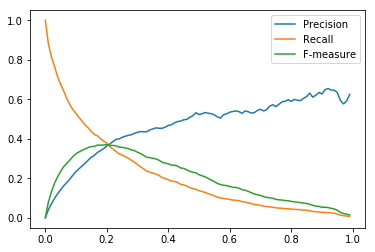

In [122]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print(precisions[0], fmeasures[0])
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
plt.show()